<span style="font-size:110%; text-align:left;"><b><a href="../index.html">5. Tips and Examples</a> > <a href="./index.html">2. General modelling</a></b></span>
<br/><br/>
<span style="font-size:200%; text-align:left;"><b>Optimising with Finesse and Pykat</b></span>
<br/><br/>
<span style="font-size:110%; text-align:left;">Author: Daniel Brown </span>

There are two way in which we can optimise parameters:
    * Externally using Pykat
    * Internally using Finesse
    
By externally, we mean that pykat generates a Finesse model for each data point and gets the output. From this output we then try and optimise some metric by changing parameters and then running a new model. This is a more flexible approach and you can incoporate whatever python code or analysis you need. However, for complex models there will be an overhead in creating and running a new model each time.

Alternatively we can do internal optimisation with Finesse. This runs an optimisation routine built in to the binary. This will require version 2.2 or higher of Finesse. Essentially we define a `func` for our metric and then use the `minmize` or `maximise` command to say what parameter we should vary to optimise the model over. This optimisation happens automatically for every xaxis step. For more complex models this method will be faster as the model is only generated once and everything is done in C code. Conversely though you will have less control over the optimisation that occurs.

# Internal Optimisation with Finesse commands

In this example we will generate ideal frequency dependent squeezing. Do to this we will optimise the squeezing input angle for each frequency. We take as an example a simplified GEO600 detector model for this. In this case we also consider a detuned interferometer for peak sensitivity around 2kHz.

In [1]:
import pykat
import matplotlib.pyplot as plt

pykat.init_pykat_plotting()

                                              ..-
    PyKat 1.1.349         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



--------------------------------------------------------------
Running kat - Started at 2019-09-03 15:17:32.200901
Used Finesse 2.2 at /Users/adf/work/bin/kat

Finished in 0.0596571 seconds


100% | ETA:  0:00:00 | Calculating                                             

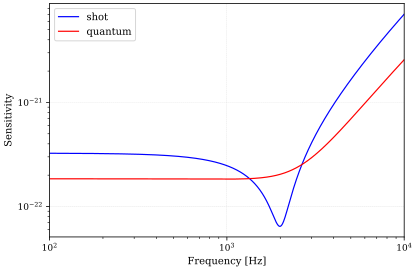

In [2]:
kat = pykat.finesse.kat()
kat.parse("""
l i1 2.0 0 0.0 nLaser
m1 MPR 0.0009 0.0 0.0 nLaser nMPR2
s swest 1.15 nMPR2 nBSwest
bs2 BS 0.5 0.0 0.0 42.834 nBSwest nBSnorth nBSi1 nBSi3
s sBS1 0.0 1.44963 nBSi1 nBSi2
s sBS2 0.0 1.44963 nBSi3 nBSi4
bs2 BS2 0.0 0.0 0.0 27.9694 nBSi2 ndump3 nBSeast nBSAR
bs2 BS3 0.0 0.0 0.0 -27.9694 nBSi4 ndump4 nBSsouth ndump5
s snorth1 600.0 nBSnorth nMFN1
bs1 MFN 0.0 0.0 0.0 0.0 nMFN1 nMFN2 ndump6 ndump7
s snorth2 600.0 nMFN2 nMCN1
m1 MCN 0.0 0 -0.001 nMCN1 ndump8
s seast1 600.0 nBSeast nMFE1
bs1 MFE 0.0 0.0 90.0 0.0 nMFE1 nMFE2 ndump9 ndump10
s seast2 600.0 nMFE2 nMCE1
m1 MCE 0.0 0 0.001 nMCE1 ndump11
s ssouth 1.0 nBSsouth nMSR1
m MSR1 0.98 0.02 -2.8843954439974606 nMSR1 nMSR2
s s_srm_isol0 0.0 nMSR2 nlossa
m mloss 0.0 1.0 0.0 nlossa nlossb
s s_srm_isol1 0.0 nlossb nisol1
dbs isol nisol1 nisol2 nisol3 nisol4

qshotS qs 1  $fs max nisol3
qnoisedS NSR2 1  $fs max nisol3

xaxis darm f log 100 10000 1000

sq sqz 0.0 10.0 0.0 nisol2

fsig darm snorth1 phase 10.0 0.0 
fsig darm1 snorth2 phase 10.0 0.0 
fsig darm2 seast1 phase 10.0 180.0 
fsig darm3 seast2 phase 10.0 180.0 

maxtem off
yaxis log abs
""")

out = kat.run()
plt.figure()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Sensitivity")
plt.xlim(out.x.min(), out.x.max())
plt.loglog(out.x, out['qs'], label="shot")
plt.loglog(out.x, out['NSR2'], label="quantum")
plt.legend()
plt.tight_layout()

Above is just the usual definitions of dual recycled michelson model. At the output we have a quantum shot noise detector for computing the vacuum noise sensitivity and a `qnoised` for computing the full quantum noise limited sensivity. Shown in the plot are the two noises, we can see the squeezed quantum noise is actually making things worse around the detuning frequency. This is because the squeezing must be frequency dependent.

Next we will add generate a function that will compute the decibel reduction in noise for the quantum noise vs shot noise. Then we specifiy the `minimize` command to minimise this with respect to the squeezing angle. We limit this to between -90 and 90 degrees and to an accuracy of $10^{-6}$. Note, the range provided is the range the routine will explore around the inital point. For example, we start at 0, we search for a minimum within -90 and 90 degrees of it. A minimum is found at 50. The next point will then be optimised for a value between 50-90 and 50+90.

In [3]:
kat.parse("""
# Set the variables to use in the function
set qs_re qs re
set NSR2_re NSR2 re

# minimize the squeezing relative to the vacuum shot noise
# level for each step along the xaxis
func reduction = 20 * log10( ( $NSR2_re + 1E-30 ) / ( $qs_re + 1E-30 ))
minimize min_angle reduction re sqz angle -90 90 1e-6
""")

Parsing `set qs_re qs re` into pykat object not implemented yet, added as extra line.
Parsing `set NSR2_re NSR2 re` into pykat object not implemented yet, added as extra line.
Parsing `minimize min_angle reduction re sqz angle -90 90 1e-6` into pykat object not implemented yet, added as extra line.


Some of these functions will not have been converted into Pykat objects yet so will highlight that they are parsed as extra lines. This will still work perfectly fine, we just won't be able to change the commands using Python objects.

Next we run the simulation:

--------------------------------------------------------------
Running kat - Started at 2019-09-03 15:17:33.221540
Used Finesse 2.2 at /Users/adf/work/bin/kat

Finished in 0.0719578 seconds


100% | ETA:  0:00:00 | Saving data                                             

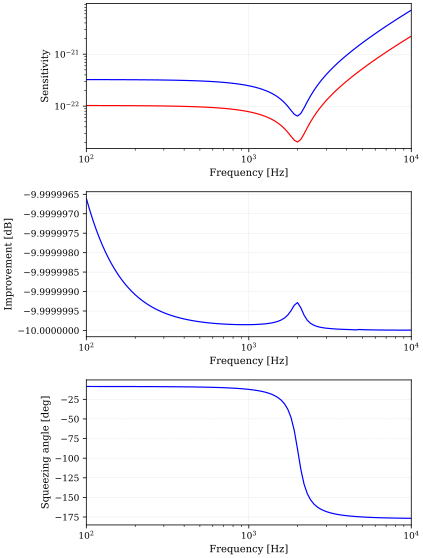

In [4]:
kat.xaxis.steps = 100
out = kat.run()

plt.figure(figsize=(6, 8))
plt.subplot(311)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Sensitivity")
plt.xlim(out.x.min(), out.x.max())
plt.loglog(out.x, out['qs'])
plt.loglog(out.x, out['NSR2'])

plt.subplot(312)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Improvement [dB]")
plt.xlim(out.x.min(), out.x.max())
plt.semilogx(out.x, out['reduction'])

plt.subplot(313)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Squeezing angle [deg]")
plt.xlim(out.x.min(), out.x.max())
plt.semilogx(out.x, out['min_angle'])

plt.tight_layout()

Above we see a nice reduction in the noise, which is pretty much 10 dB better over the frequency range. We also can see the minimised parameter value, in this case the squeezing angle. This shows us the ideal frequency dependent source for this model.

# External optimisation with Pykat

Now let us consider the same optimisation problem but not using the `minimize` command. There are acually many ways in which you could acomplish this. You could do a 2D output from Finesse and find the minimum noise values in that, you could break it down into a for loop over frequency and a 1D Finesse model over squeezing angle and find the minimum in that, or you could use the optimisation routines from Scipy. The former methods should be fairly straight forward to accomplish. Here I will show how to use the Scipy routines as they have some nice optimisation code.

In [5]:
kat = pykat.finesse.kat()
kat.parse("""
l i1 2.0 0 0.0 nLaser
m1 MPR 0.0009 0.0 0.0 nLaser nMPR2
s swest 1.15 nMPR2 nBSwest
bs2 BS 0.5 0.0 0.0 42.834 nBSwest nBSnorth nBSi1 nBSi3
s sBS1 0.0 1.44963 nBSi1 nBSi2
s sBS2 0.0 1.44963 nBSi3 nBSi4
bs2 BS2 0.0 0.0 0.0 27.9694 nBSi2 ndump3 nBSeast nBSAR
bs2 BS3 0.0 0.0 0.0 -27.9694 nBSi4 ndump4 nBSsouth ndump5
s snorth1 600.0 nBSnorth nMFN1
bs1 MFN 0.0 0.0 0.0 0.0 nMFN1 nMFN2 ndump6 ndump7
s snorth2 600.0 nMFN2 nMCN1
m1 MCN 0.0 0 -0.001 nMCN1 ndump8
s seast1 600.0 nBSeast nMFE1
bs1 MFE 0.0 0.0 90.0 0.0 nMFE1 nMFE2 ndump9 ndump10
s seast2 600.0 nMFE2 nMCE1
m1 MCE 0.0 0 0.001 nMCE1 ndump11
s ssouth 1.0 nBSsouth nMSR1
m MSR1 0.98 0.02 -2.8843954439974606 nMSR1 nMSR2
s s_srm_isol0 0.0 nMSR2 nlossa
m mloss 0.0 1.0 0.0 nlossa nlossb
s s_srm_isol1 0.0 nlossb nisol1
dbs isol nisol1 nisol2 nisol3 nisol4

qshotS qs 1  $fs max nisol3
qnoisedS NSR2 1  $fs max nisol3

sq sqz 0.0 10.0 0.0 nisol2

fsig darm snorth1 phase 10.0 0.0 
fsig darm1 snorth2 phase 10.0 0.0 
fsig darm2 seast1 phase 10.0 180.0 
fsig darm3 seast2 phase 10.0 180.0 

maxtem off
yaxis log abs
""")

In [6]:
from scipy.optimize import minimize_scalar
import numpy as np

In [7]:
i = 0
freqs = np.logspace(2, 4, 10)

qnoise = np.zeros_like(freqs)
shotnoise = np.zeros_like(freqs)
reduction = np.zeros_like(freqs)
min_angle = np.zeros_like(freqs)

def func(angle):
    # Here we set up a model to only compute a single data point
    # and run
    kat.sqz.angle = angle
    kat.noxaxis = True
    kat.verbose = False
    out = kat.run()
    
    qnoise[i] = float(out['NSR2'])
    shotnoise[i] = float(out['qs'])
    
    # return the reduction result
    return 20 * np.log10(out['NSR2']/out['qs'])

for f in freqs:
    kat.signals.f = f # Set which frequency to compute for
    
    # Now minimise the noise over squeezing angle
    x = minimize_scalar(func, tol=1e-6)
    
    reduction[i] = x.fun
    min_angle[i] = x.x
    
    i += 1

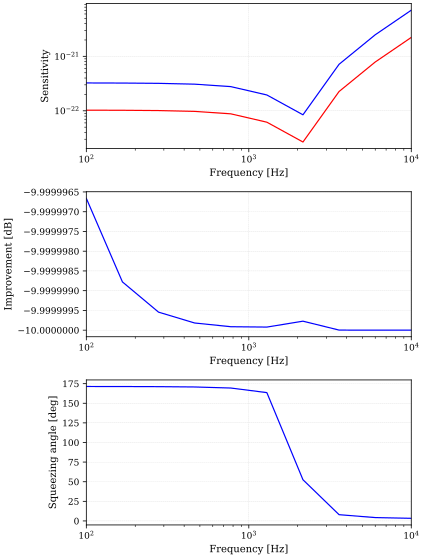

In [8]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Sensitivity")
plt.xlim(freqs.min(), freqs.max())
plt.loglog(freqs, shotnoise)
plt.loglog(freqs, qnoise)

plt.subplot(312)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Improvement [dB]")
plt.xlim(freqs.min(), freqs.max())
plt.semilogx(freqs, reduction)

plt.subplot(313)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Squeezing angle [deg]")
plt.xlim(freqs.min(), freqs.max())
plt.semilogx(freqs, min_angle % 180)

plt.tight_layout()

And as we can see we end up with a solution similar to the internal optimisation, albeit much slower.